In [2]:
# Шаг 1: Подготовка датасета
# В Google Colab для скачивания с Kaggle
!pip install kaggle
!mkdir -p ~/.kaggle

# Загрузите свой kaggle.json (нужен аккаунт Kaggle)
from google.colab import files
files.upload()  # Загрузите kaggle.json

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Скачиваем датасет
!kaggle datasets download -d aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes
!unzip austin-animal-center-shelter-intakes-and-outcomes.zip

Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes
License(s): ODbL-1.0
austin-animal-center-shelter-intakes-and-outcomes.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  austin-animal-center-shelter-intakes-and-outcomes.zip
  inflating: aac_intakes.csv         
  inflating: aac_intakes_outcomes.csv  
  inflating: aac_outcomes.csv        


In [3]:
# Шаг 2: # Создаем папку data и перемещаем файлы
!mkdir -p data
!mv aac_intakes.csv data/
!mv aac_outcomes.csv data/
!mv aac_intakes_outcomes.csv data/

# Проверяем
!ls -la data/


total 54828
drwxr-xr-x 2 root root     4096 Sep 21 01:44 .
drwxr-xr-x 1 root root     4096 Sep 21 01:44 ..
-rw-r--r-- 1 root root 13040169 Sep 29  2019 aac_intakes.csv
-rw-r--r-- 1 root root 31441583 Sep 29  2019 aac_intakes_outcomes.csv
-rw-r--r-- 1 root root 11648624 Sep 29  2019 aac_outcomes.csv


In [ ]:
# Шаг 3: Создание файлов проекта

In [4]:
%%writefile requirements.txt
Numpy==2.3.3
pandas==2.3.2
matplotlib==3.10.6
seaborn==0.12.2

Writing requirements.txt


In [5]:
%%writefile database.py
import sqlite3
import pandas as pd
import os

def delete_existing_database():
    """Удаление существующей базы данных, если она есть"""
    print("Проверяем существующую базу данных...")
    if os.path.exists('animal_shelter.db'):
        os.remove('animal_shelter.db')
        print("Существующая база данных удалена")
    else:
        print("База данных не существует, создаем новую")

def print_table_sample(conn, table_name, limit=20):
    """Вывод sample данных из таблицы"""
    print(f"\nСодержимое таблицы {table_name} (первые {limit} записей):")
    print("-" * 60)
    try:
        query = f"SELECT * FROM {table_name} LIMIT {limit}"
        df = pd.read_sql_query(query, conn)
        if len(df) > 0:
            print(df.to_string(index=False))
            print(f"Всего записей в таблице: {pd.read_sql_query(f'SELECT COUNT(*) FROM {table_name}', conn).iloc[0,0]}")
        else:
            print("Таблица пуста")
    except Exception as e:
        print(f"❌ Ошибка при чтении таблицы {table_name}: {e}")

def print_view_sample(conn, view_name, limit=20):
    """Вывод sample данных из view"""
    print(f"\nСодержимое view {view_name} (первые {limit} записей):")
    print("-" * 60)
    try:
        query = f"SELECT * FROM {view_name} LIMIT {limit}"
        df = pd.read_sql_query(query, conn)
        if len(df) > 0:
            print(df.to_string(index=False))
            print(f"Всего записей в view: {pd.read_sql_query(f'SELECT COUNT(*) FROM {view_name}', conn).iloc[0,0]}")
        else:
            print("Представление пустое")
    except Exception as e:
        print(f"Ошибка при чтении view {view_name}: {e}")

def create_raw_tables():
    """Создание сырых таблиц - копий CSV файлов"""
    print("\nЗагружаем CSV файлы в сырые таблицы...")

    conn = sqlite3.connect('animal_shelter.db')

    try:
        # Загрузка данных в сырые таблицы
        print("Загружаем aac_intakes.csv...")
        intake_df = pd.read_csv('data/aac_intakes.csv')
        print("Загружаем aac_outcomes.csv...")
        outcome_df = pd.read_csv('data/aac_outcomes.csv')
        print("Загружаем aac_intakes_outcomes.csv...")
        intake_outcome_df = pd.read_csv('data/aac_intakes_outcomes.csv')

        # Создаем сырые таблицы
        print("Сохраняем raw_intake...")
        intake_df.to_sql('raw_intake', conn, if_exists='replace', index=False)
        print("Сохраняем raw_outcome...")
        outcome_df.to_sql('raw_outcome', conn, if_exists='replace', index=False)
        print("Сохраняем raw_intake_outcome...")
        intake_outcome_df.to_sql('raw_intake_outcome', conn, if_exists='replace', index=False)

        print("Сырые таблицы созданы успешно")
        print()

        print_table_sample(conn, 'raw_intake')
        print_table_sample(conn, 'raw_outcome')

    except Exception as e:
        print(f"❌ Ошибка при создании сырых таблиц: {e}")
        raise
    finally:
        conn.close()

def create_temp_views():
    """Создание временных представлений для анализа"""
    print("\nСоздаем временные представления для анализа...")

    conn = sqlite3.connect('animal_shelter.db')
    cursor = conn.cursor()

    try:
        # Временное представление для уникальных животных
        print("Создаем представление unique_animals...")
        cursor.execute('''
        CREATE VIEW IF NOT EXISTS unique_animals AS
        SELECT DISTINCT
            animal_id,
            name,
            animal_type,
            breed,
            color
        FROM (
            SELECT animal_id, name, animal_type, breed, color FROM raw_intake
            UNION
            SELECT animal_id, name, animal_type, breed, color FROM raw_outcome
             )
        ''')

        # Временное представление для статистики типов животных
        print("Создаем представление animal_type_stats...")
        cursor.execute('''
        CREATE VIEW IF NOT EXISTS animal_type_stats AS
        SELECT
            animal_type,
            COUNT(*) as count,
            ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM unique_animals), 2) as percentage
        FROM unique_animals
        GROUP BY animal_type
        ORDER BY count DESC
        ''')

        # Временное представление для статистики пород
        print("Создаем представление breed_stats...")
        cursor.execute('''
        CREATE VIEW IF NOT EXISTS breed_stats AS
        SELECT
            breed,
            COUNT(*) as count,
            ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM unique_animals), 2) as percentage
        FROM unique_animals
        GROUP BY breed
        ORDER BY count DESC
        ''')

        conn.commit()
        print("Временные представления созданы успешно")

        # Выводим sample данных из представлений
        print_table_sample(conn, 'unique_animals')
        print_table_sample(conn, 'animal_type_stats')
        print_table_sample(conn, 'breed_stats')

    except Exception as e:
        print(f"❌ Ошибка при создании временных представлений: {e}")
        raise
    finally:
        conn.close()

def analyze_raw_data():
    """Анализ сырых данных перед обработкой"""
    print("\nАнализируем сырые данные...")

    conn = sqlite3.connect('animal_shelter.db')

    try:
        # Основная статистика
        print("Основная статистика:")
        intake_count = pd.read_sql_query("SELECT COUNT(*) FROM raw_intake", conn).iloc[0,0]
        outcome_count = pd.read_sql_query("SELECT COUNT(*) FROM raw_outcome", conn).iloc[0,0]
        unique_animals_count = pd.read_sql_query("SELECT COUNT(*) FROM unique_animals", conn).iloc[0,0]

        print(f"   Поступления (intake): {intake_count} записей")
        print(f"   Исходы (outcome): {outcome_count} записей")
        print(f"   Уникальных животных: {unique_animals_count}")

        # Статистика по типам животных
        print("\nРаспределение по типам животных:")
        type_stats = pd.read_sql_query("SELECT * FROM animal_type_stats", conn)
        for _, row in type_stats.iterrows():
            print(f"   {row['animal_type']}: {row['count']} ({row['percentage']}%)")

        # Топ-5 пород
        print("\nТоп-5 пород:")
        breed_stats = pd.read_sql_query("SELECT * FROM breed_stats LIMIT 5", conn)
        for _, row in breed_stats.iterrows():
            print(f"   {row['breed']}: {row['count']} ({row['percentage']}%)")

    except Exception as e:
        print(f"❌ Ошибка при анализе данных: {e}")
        raise
    finally:
        conn.close()

def create_normalized_tables():
    """Создание нормализованных таблиц со справочниками"""
    print("\nСоздаем нормализованную структуру...")

    conn = sqlite3.connect('animal_shelter.db')
    cursor = conn.cursor()

    try:
        # 1. Создаем справочник типов животных
        print("Создаем сравочник animal_types...")
        cursor.execute('''
        CREATE TABLE animal_types (
            type_id INTEGER PRIMARY KEY AUTOINCREMENT,
            animal_type TEXT UNIQUE NOT NULL
        )
        ''')

        cursor.execute('''
        INSERT OR IGNORE INTO animal_types (animal_type)
        SELECT DISTINCT animal_type FROM (
            SELECT animal_type FROM raw_intake
            UNION
            SELECT animal_type FROM raw_outcome
        )
        ''')
        print(f"   Добавлено записей: {cursor.rowcount}")

        # 2. Создаем справочник окрасов
        print("Создаем справочник colors...")
        cursor.execute('''
        CREATE TABLE colors (
            color_id INTEGER PRIMARY KEY AUTOINCREMENT,
            color_name TEXT UNIQUE NOT NULL
        )
        ''')

        cursor.execute('''
        INSERT OR IGNORE INTO colors (color_name)
        SELECT DISTINCT color FROM (
            SELECT color FROM raw_intake
            UNION
            SELECT color FROM raw_outcome
        )
        ''')
        print(f"   Добавлено записей: {cursor.rowcount}")

        # 3. Создаем справочник пород
        print("Создаем справочник breeds...")
        cursor.execute('''
        CREATE TABLE breeds (
            breed_id INTEGER PRIMARY KEY AUTOINCREMENT,
            breed_name TEXT UNIQUE NOT NULL
        )
        ''')

        cursor.execute('''
        INSERT OR IGNORE INTO breeds (breed_name)
        SELECT DISTINCT breed FROM (
            SELECT breed FROM raw_intake
            UNION
            SELECT breed FROM raw_outcome
        )
        ''')
        print(f"   Добавлено записей: {cursor.rowcount}")

        # 4. Создаем основную таблицу животных
        print("Создаем таблицу animals...")
        cursor.execute('''
        CREATE TABLE animals (
            animal_id TEXT PRIMARY KEY,
            name TEXT,
            animal_type_id INTEGER,
            breed_id INTEGER,
            color_id INTEGER,
            FOREIGN KEY (animal_type_id) REFERENCES animal_types(type_id),
            FOREIGN KEY (breed_id) REFERENCES breeds(breed_id),
            FOREIGN KEY (color_id) REFERENCES colors(color_id)
        )
        ''')

        # Заполняем таблицу животных
        print("Заполняем таблицу animals...")
        cursor.execute('''
        INSERT OR REPLACE INTO animals (animal_id, name, animal_type_id, breed_id, color_id)
        SELECT
            ua.animal_id,
            ua.name,
            at.type_id,
            b.breed_id,
            c.color_id
        FROM unique_animals ua
        JOIN animal_types at ON ua.animal_type = at.animal_type
        JOIN breeds b ON ua.breed = b.breed_name
        JOIN colors c ON ua.color = c.color_name
        ''')
        print(f"   Добавлено животных: {cursor.rowcount}")

        # 5. Создаем таблицу поступлений
        print("Создаем таблицу intake...")
        cursor.execute('''
        CREATE TABLE intake (
            intake_id INTEGER PRIMARY KEY AUTOINCREMENT,
            animal_id TEXT,
            intake_date TEXT NOT NULL,
            intake_type TEXT,
            intake_condition TEXT,
            found_location TEXT,
            FOREIGN KEY (animal_id) REFERENCES animals(animal_id)
        )
        ''')

        cursor.execute('''
        INSERT INTO intake (animal_id, intake_date, intake_type, intake_condition, found_location)
        SELECT
            animal_id,
            datetime,
            intake_type,
            intake_condition,
            found_location
        FROM raw_intake
        ''')
        print(f"   Добавлено поступлений: {cursor.rowcount}")

        # 6. Создаем таблицу выходов
        print("Создаем таблицу outcome...")
        cursor.execute('''
        CREATE TABLE outcome (
            outcome_id INTEGER PRIMARY KEY AUTOINCREMENT,
            animal_id TEXT,
            outcome_date TEXT NOT NULL,
            outcome_type TEXT,
            outcome_subtype TEXT,
            days_in_shelter INTEGER,
            FOREIGN KEY (animal_id) REFERENCES animals(animal_id)
        )
        ''')

        cursor.execute('''
        INSERT INTO outcome (animal_id, outcome_date, outcome_type, outcome_subtype, days_in_shelter)
        SELECT
            raw_outcome.animal_id,
            raw_outcome.datetime,
            raw_outcome.outcome_type,
            raw_outcome.outcome_subtype,
            case when coalesce(raw_outcome.datetime,0) <> 0 and coalesce(raw_intake.datetime,0) <> 0 and coalesce(raw_outcome.datetime,0) > coalesce(raw_intake.datetime,0)
                 then julianday(raw_outcome.datetime) - julianday(raw_intake.datetime)
                 else null
            end
        FROM raw_outcome
        left join raw_intake on raw_outcome.animal_id=raw_intake.animal_id
        ''')
        print(f"   Добавлено выходов: {cursor.rowcount}")

        conn.commit()
        print("Нормализованная структура создана успешно")

    except Exception as e:
        print(f"❌ Ошибка при создании нормализованной структуры: {e}")
        raise
    finally:
        conn.close()

def drop_temp_views():
    """Удаление временных представлений"""
    print("\nУдаляем временные представления...")

    conn = sqlite3.connect('animal_shelter.db')
    cursor = conn.cursor()

    try:
        views = ['unique_animals', 'animal_type_stats', 'breed_stats']
        for view in views:
            cursor.execute(f"DROP VIEW IF EXISTS {view}")
            print(f"   Удалено представление: {view}")

        conn.commit()
        print("Временные представления удалены")

    except Exception as e:
        print(f"❌ Ошибка при удалении представлений: {e}")
        raise
    finally:
        conn.close()

def print_database_structure():
    """Вывод структуры базы данных и примеров данных"""

    conn = sqlite3.connect('animal_shelter.db')
    cursor = conn.cursor()

    try:
        # Получаем список всех таблиц
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
        tables = cursor.fetchall()

        print("Таблицы в базе данных:")
        for table in tables:
            table_name = table[0]
            cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
            count = cursor.fetchone()[0]
            print(f"   ├─ {table_name}: {count} записей")

        # Статистика по нормализованным таблицам
        print("\nСтатистика нормализованных таблиц:")
        normalized_tables = ['animal_types', 'breeds', 'colors', 'animals', 'intake', 'outcome']

        for table in normalized_tables:
            cursor.execute(f"SELECT COUNT(*) FROM {table}")
            count = cursor.fetchone()[0]
            print(f"   ├─ {table}: {count} записей")

        print_table_sample(conn, 'animal_types')
        print_table_sample(conn, 'breeds')
        print_table_sample(conn, 'colors')
        print_table_sample(conn, 'animals')
        print_table_sample(conn, 'intake')
        print_table_sample(conn, 'outcome')

    except Exception as e:
        print(f"❌ Ошибка при выводе структуры: {e}")
        raise
    finally:
        conn.close()

Overwriting database.py


In [6]:
%%writefile visualization.py
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import pandas as pd
import numpy as np

def execute_queries():
    """Сложные SQL-запросы с JOIN"""

    conn = sqlite3.connect('animal_shelter.db')

    try:
        print("=" * 60)
        print("\n1. Количество животных по типам:")
        query = '''
        SELECT at.animal_type, COUNT(*) as count
        FROM animals a
        JOIN animal_types at ON a.animal_type_id = at.type_id
        GROUP BY at.animal_type
        ORDER BY count DESC
        '''
        df = pd.read_sql_query(query, conn)
        print(df.to_string(index=False))

        print("=" * 60)
        print("\n2. Top 10 самых распространенных пород:")
        query = '''
        SELECT b.breed_name, COUNT(*) as count
        FROM animals a
        JOIN breeds b ON a.breed_id = b.breed_id
        GROUP BY b.breed_name
        ORDER BY count DESC
        LIMIT 10
        '''
        df = pd.read_sql_query(query, conn)
        print(df.to_string(index=False))

        print("=" * 60)
        print("\n3. Статистика по выходу из приюта (outcome types):")
        query = '''
        SELECT outcome_type, COUNT(*) as count,
               ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM outcome), 2) as percentage
        FROM outcome
        GROUP BY outcome_type
        ORDER BY count DESC
        '''
        df = pd.read_sql_query(query, conn)
        print(df.to_string(index=False))

        print("=" * 60)
        print("\n4. Среднее время пребывания в приюте по типам животных:")
        query = '''
        SELECT at.animal_type,
               ROUND(AVG(o.days_in_shelter), 2) as avg_days
        FROM outcome o
        JOIN animals a ON o.animal_id = a.animal_id
        JOIN animal_types at ON a.animal_type_id = at.type_id
        WHERE o.days_in_shelter IS NOT NULL
        GROUP BY at.animal_type
        ORDER BY avg_days DESC
        '''
        df = pd.read_sql_query(query, conn)
        print(df.to_string(index=False))

        print("=" * 60)
        print("\n5. Статистика по месяцам поступлений:")
        query = '''
        SELECT
            strftime('%Y-%m', intake_date) as month,
            COUNT(*) as count
        FROM intake
        WHERE intake_date IS NOT NULL
        GROUP BY month
        ORDER BY month
        LIMIT 24
        '''
        df = pd.read_sql_query(query, conn)
        print(df.to_string(index=False))

    except Exception as e:
        print(f"❌ Ошибка при выполнении запросов: {e}")
        raise
    finally:
        conn.close()

def create_visualizations():
    """Визуализация данных из нормализованной БД"""

    conn = sqlite3.connect('animal_shelter.db')

    try:
        # Распределение по типам животных
        print()
        print()
        print()
        query = '''
        SELECT at.animal_type, COUNT(*) as count
        FROM animals a
        JOIN animal_types at ON a.animal_type_id = at.type_id
        GROUP BY at.animal_type
        '''
        df = pd.read_sql_query(query, conn)

        plt.figure(figsize=(12, 6))
        bars = plt.bar(df['animal_type'], df['count'])
        plt.title('Распределение животных по типам в приюте', fontsize=16, fontweight='bold')
        plt.xlabel('Тип животного', fontsize=12)
        plt.ylabel('Количество', fontsize=12)
        plt.xticks(rotation=45, ha='right')

        # Добавляем значения на столбцы
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 5,
                    f'{int(height)}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        # Выходы из приюта (круговая диаграмма)
        print()
        print()
        print()
        query = "SELECT outcome_type, COUNT(*) as count FROM outcome GROUP BY outcome_type"
        df = pd.read_sql_query(query, conn)

        plt.figure(figsize=(10, 8))
        colors = plt.cm.Set3(np.linspace(0, 1, len(df)))
        wedges, texts, autotexts = plt.pie(df['count'], labels=df['outcome_type'], autopct='%1.1f%%',
                                          colors=colors, startangle=90)
        plt.title('Распределение выходов из приюта', fontsize=16, fontweight='bold')
        plt.axis('equal')
        plt.show()

        # Время пребывания в приюте
        print()
        print()
        print()
        query = '''
        SELECT at.animal_type, AVG(o.days_in_shelter) as avg_days
        FROM outcome o
        JOIN animals a ON o.animal_id = a.animal_id
        JOIN animal_types at ON a.animal_type_id = at.type_id
        WHERE o.days_in_shelter IS NOT NULL
        GROUP BY at.animal_type
        '''
        df = pd.read_sql_query(query, conn)

        plt.figure(figsize=(12, 6))
        bars = plt.bar(df['animal_type'], df['avg_days'])
        plt.title('Среднее время пребывания в приюте по типам животных', fontsize=16, fontweight='bold')
        plt.xlabel('Тип животного', fontsize=12)
        plt.ylabel('Среднее количество дней', fontsize=12)
        plt.xticks(rotation=45, ha='right')

        # Добавляем значения на столбцы
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:.1f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        # Типы поступлений в приют
        print()
        print()
        print()
        query = "SELECT intake_type, COUNT(*) as count FROM intake GROUP BY intake_type"
        df = pd.read_sql_query(query, conn)

        plt.figure(figsize=(10, 6))
        bars = plt.bar(df['intake_type'], df['count'])
        plt.title('Типы поступлений в приют', fontsize=16, fontweight='bold')
        plt.xlabel('Тип поступления', fontsize=12)
        plt.ylabel('Количество', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Динамика поступлений по месяцам
        print()
        print()
        print()
        query = '''
        SELECT
            strftime('%Y-%m', intake_date) as month,
            COUNT(*) as count
        FROM intake
        WHERE intake_date IS NOT NULL
        GROUP BY month
        ORDER BY month
        '''
        df = pd.read_sql_query(query, conn)

        plt.figure(figsize=(14, 6))
        plt.plot(df['month'], df['count'], marker='o', linewidth=2, markersize=6)
        plt.title('Динамика поступлений животных по месяцам', fontsize=16, fontweight='bold')
        plt.xlabel('Месяц', fontsize=12)
        plt.ylabel('Количество поступлений', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print("Визуализации созданы успешно!")

    except Exception as e:
        print(f"❌ Ошибка при создании визуализаций: {e}")
        raise
    finally:
        conn.close()

def perform_additional_analysis():
    """Дополнительный анализ данных"""
    print("Дополнительный анализ данных")

    conn = sqlite3.connect('animal_shelter.db')

    try:
        # Анализ сезонности поступлений
        print("=" * 60)
        print("Анализ сезонности поступлений:")
        season_query = '''
        SELECT
            CASE
                WHEN strftime('%m', intake_date) IN ('12', '01', '02') THEN 'Зима'
                WHEN strftime('%m', intake_date) IN ('03', '04', '05') THEN 'Весна'
                WHEN strftime('%m', intake_date) IN ('06', '07', '08') THEN 'Лето'
                WHEN strftime('%m', intake_date) IN ('09', '10', '11') THEN 'Осень'
            END as season,
            COUNT(*) as count
        FROM intake
        WHERE intake_date IS NOT NULL
        GROUP BY season
        ORDER BY count DESC
        '''
        season_df = pd.read_sql_query(season_query, conn)
        print(season_df.to_string(index=False))

        # Анализ по времени суток
        print("=" * 60)
        print("\nАнализ по времени суток:")
        time_query = '''
        SELECT
            CASE
                WHEN CAST(strftime('%H', intake_date) AS INTEGER) BETWEEN 6 AND 11 THEN 'Утро (6-12)'
                WHEN CAST(strftime('%H', intake_date) AS INTEGER) BETWEEN 12 AND 17 THEN 'День (12-18)'
                WHEN CAST(strftime('%H', intake_date) AS INTEGER) BETWEEN 18 AND 23 THEN 'Вечер (18-24)'
                ELSE 'Ночь (0-6)'
            END as time_of_day,
            COUNT(*) as count
        FROM intake
        WHERE intake_date IS NOT NULL
        GROUP BY time_of_day
        ORDER BY count DESC
        '''
        time_df = pd.read_sql_query(time_query, conn)
        print(time_df.to_string(index=False))

        # Статистика по условиям поступления
        print("=" * 60)
        print("\nСтатистика по условиям поступления:")
        condition_query = '''
        SELECT
            intake_condition,
            COUNT(*) as count,
            ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM intake), 2) as percentage
        FROM intake
        GROUP BY intake_condition
        ORDER BY count DESC
        '''
        condition_df = pd.read_sql_query(condition_query, conn)
        print(condition_df.to_string(index=False))

        print("=" * 60)
        print("\nЖивотные с несколькими поступлениями:")
        query = '''
        WITH intake_counts AS (
            SELECT
                animal_id,
                COUNT(*) as intake_count,
                MIN(intake_date) as first_intake,
                MAX(intake_date) as last_intake
            FROM intake
            GROUP BY animal_id
            HAVING COUNT(*) > 1
            ORDER BY intake_count DESC
        )
        SELECT
            ic.animal_id,
            a.name,
            ic.intake_count,
            strftime('%d.%m.%Y %H:%M', ic.first_intake) as first_intake,
            strftime('%d.%m.%Y %H:%M', ic.last_intake) as last_intake,
            cast(JULIANDAY(ic.last_intake) - JULIANDAY(ic.first_intake) as integer) as days_between_first_last
        FROM intake_counts ic
        JOIN animals a ON ic.animal_id = a.animal_id
        ORDER BY ic.intake_count DESC
        LIMIT 15
        '''
        df_multiple_intakes = pd.read_sql_query(query, conn)
        print(df_multiple_intakes.to_string(index=False))


    except Exception as e:
        print(f"❌ Ошибка при дополнительном анализе: {e}")
    finally:
        conn.close()



Overwriting visualization.py



СИСТЕМА АНАЛИЗА ДАННЫХ ПРИЮТА ДЛЯ ЖИВОТНЫХ
Проверяем наличие CSV файлов...
data/aac_intakes.csv (13040169 байт)
data/aac_outcomes.csv (11648624 байт)

1. ПОДГОТОВКА БАЗЫ ДАННЫХ
Проверяем существующую базу данных...
Существующая база данных удалена

2. СОЗДАНИЕ СЫРЫХ ТАБЛИЦ

Загружаем CSV файлы в сырые таблицы...
Загружаем aac_intakes.csv...
Загружаем aac_outcomes.csv...
Загружаем aac_intakes_outcomes.csv...
Сохраняем raw_intake...
Сохраняем raw_outcome...
Сохраняем raw_intake_outcome...
Сырые таблицы созданы успешно


Содержимое таблицы raw_intake (первые 20 записей):
------------------------------------------------------------
age_upon_intake animal_id animal_type                                    breed             color                datetime               datetime2                                   found_location intake_condition     intake_type        name sex_upon_intake
        8 years   A706918         Dog                 English Springer Spaniel       White/Liver 2015-07-05T

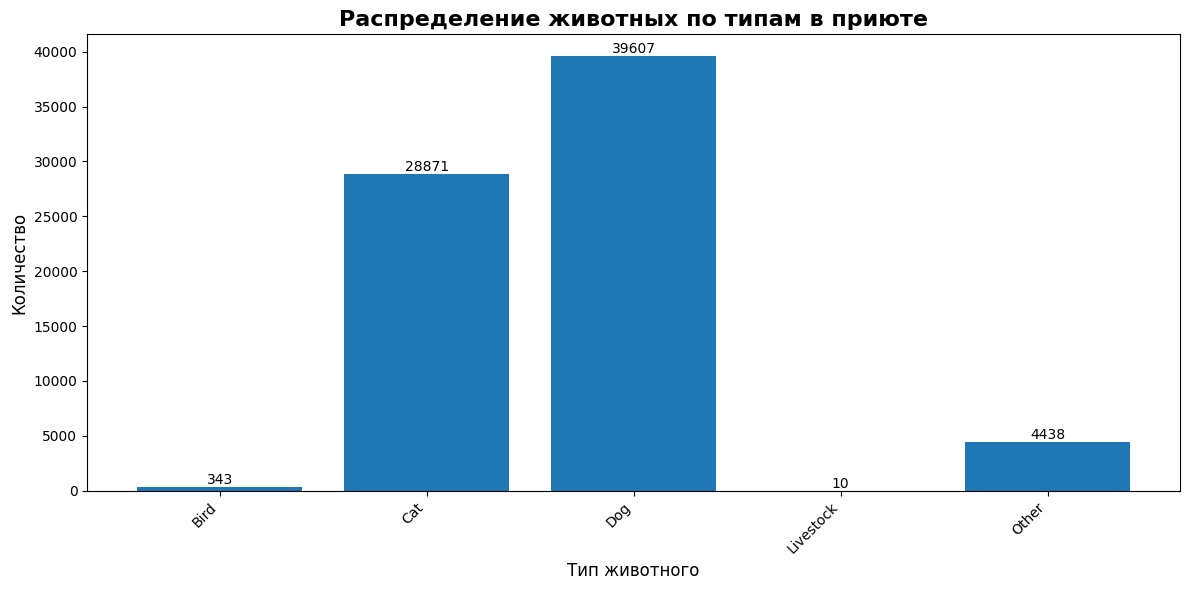

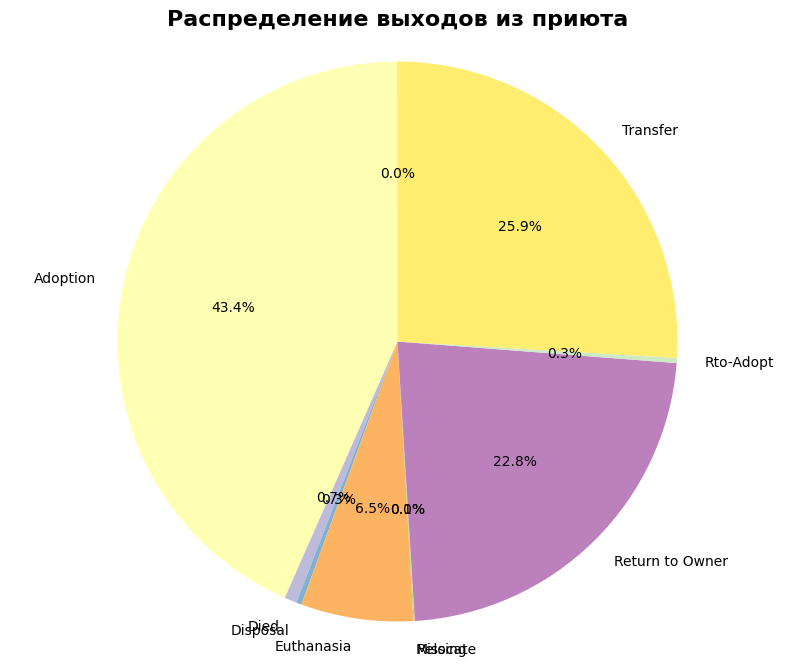

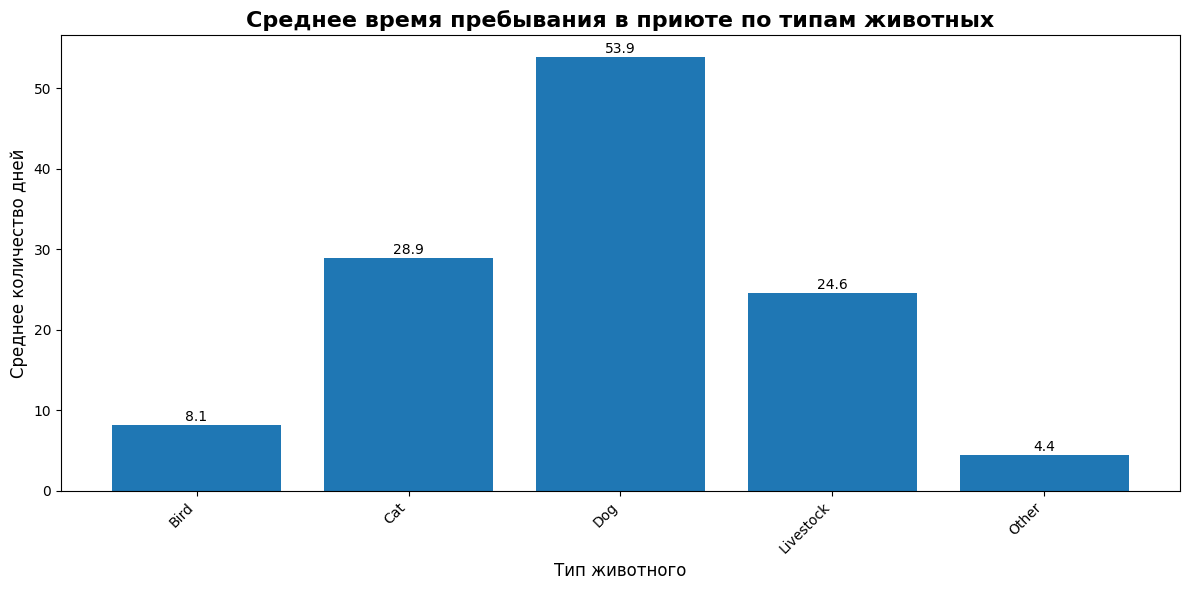

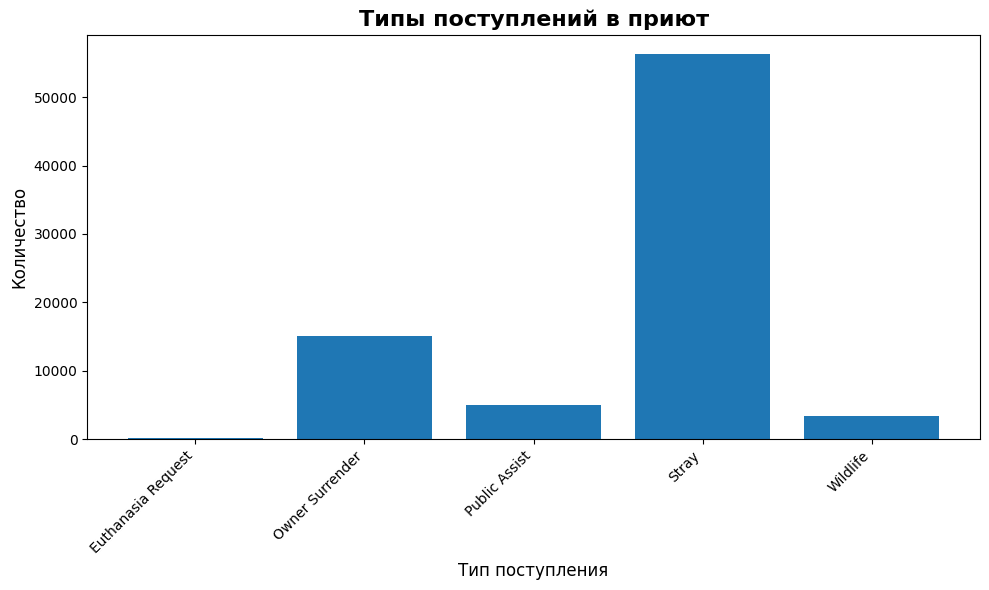

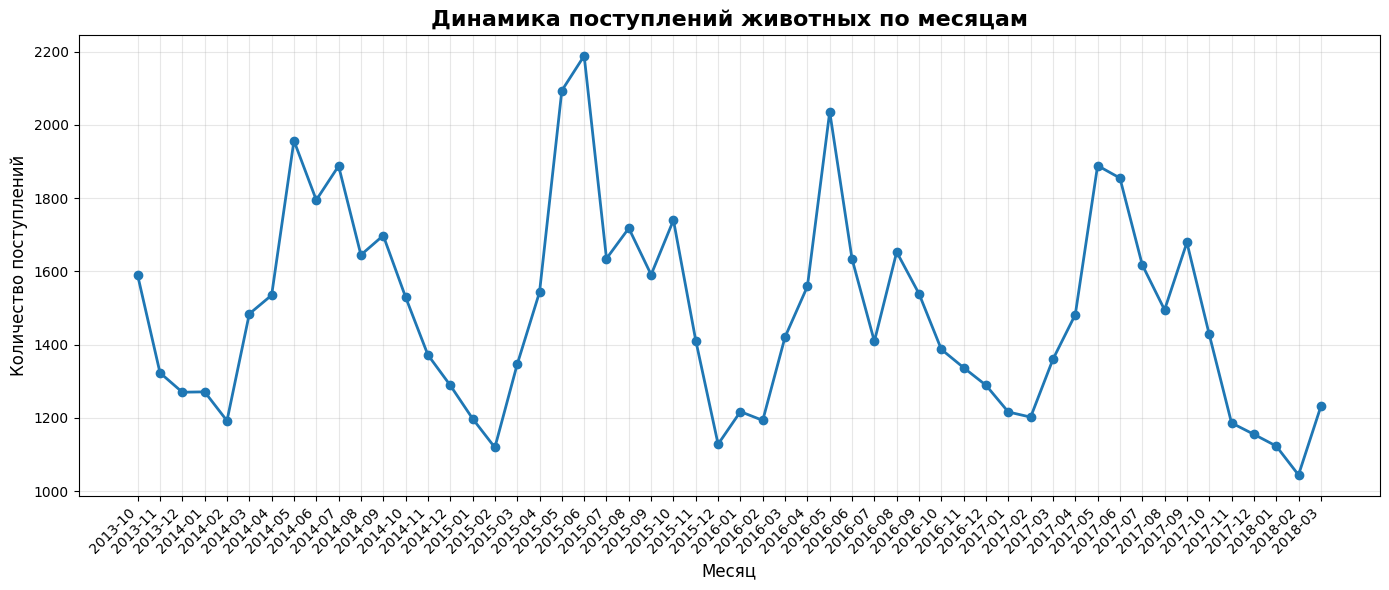

Визуализации созданы успешно!


ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ
Дополнительный анализ данных
Анализ сезонности поступлений:
season  count
 Весна  20937
 Осень  20810
  Лето  20534
  Зима  17906

Анализ по времени суток:
  time_of_day  count
 День (12-18)  50674
  Утро (6-12)  21096
Вечер (18-24)   7773
   Ночь (0-6)    644

Статистика по условиям поступления:
intake_condition  count  percentage
          Normal  70520       87.94
         Injured   4023        5.02
            Sick   3107        3.87
         Nursing   1925        2.40
            Aged    322        0.40
           Other    149        0.19
           Feral     92        0.11
        Pregnant     49        0.06

Животные с несколькими поступлениями:
animal_id       name  intake_count     first_intake      last_intake  days_between_first_last
  A721033    Lil Bit            13 20.02.2016 10:44 14.03.2018 10:57                      753
  A718223      Bubba            11 25.12.2015 11:41 19.01.2018 10:19                      

In [ ]:
# main.py
import pandas as pd
import sqlite3
import os
from database import (delete_existing_database, create_raw_tables,
                     create_temp_views, analyze_raw_data,
                     create_normalized_tables, drop_temp_views,
                     print_database_structure)

from visualization import (execute_queries, create_visualizations, perform_additional_analysis)

def check_data_files():
    """Проверка наличия CSV файлов"""
    print("Проверяем наличие CSV файлов...")

    required_files = [
        'data/aac_intakes.csv',
        'data/aac_outcomes.csv'
    ]

    all_files_exist = True
    for file in required_files:
        if os.path.exists(file):
            size = os.path.getsize(file)
            print(f"{file} ({size} байт)")
        else:
            print(f"{file} - ОТСУТСТВУЕТ!")
            all_files_exist = False

    return all_files_exist

def analyze_with_visualizations():
    """Проведение анализа с визуализацией данных"""
    print("\n" + "=" * 60)
    print("8. АНАЛИТИКА И ВИЗУАЛИЗАЦИЯ ДАННЫХ")
    print("=" * 60)

    try:
        print("\n" + "=" * 60)
        print("\nВЫПОЛНЯЕМ АНАЛИТИЧЕСКИЕ ЗАПРОСЫ")
        print("=" * 60)
        execute_queries()

        print("\n" + "=" * 60)
        print("\nСОЗДАЕМ ВИЗУАЛИЗАЦИИ ДАННЫХ")
        print("=" * 60)
        create_visualizations()

        print("\n" + "=" * 60)
        print("\nДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ")
        print("=" * 60)
        perform_additional_analysis()

        print("\n" + "=" * 60)
        print("Аналитика и визуализация завершены успешно!")
        print("=" * 60)

    except Exception as e:
        print(f"❌ Ошибка при анализе и визуализации: {e}")

def main():
    print("\n" + "=" * 60)
    print("СИСТЕМА АНАЛИЗА ДАННЫХ ПРИЮТА ДЛЯ ЖИВОТНЫХ")
    print("=" * 60)

    # Проверяем файлы
    if not check_data_files():
        print("\nПрограмма остановлена: отсутствуют необходимые файлы")
        return

    try:
        # 1. Создаем базу данных
        print("\n" + "=" * 60)
        print("1. ПОДГОТОВКА БАЗЫ ДАННЫХ")
        print("=" * 60)
        delete_existing_database()

        # 2. Создаем сырые таблицы
        print("\n" + "=" * 60)
        print("2. СОЗДАНИЕ СЫРЫХ ТАБЛИЦ")
        print("=" * 60)
        create_raw_tables()

        # 3. Создаем временные представления
        print("\n" + "=" * 60)
        print("3. СОЗДАНИЕ ВРЕМЕННЫХ ПРЕДСТАВЛЕНИЙ")
        print("=" * 60)
        create_temp_views()

        # 4. Анализируем сырые данные
        print("\n" + "=" * 60)
        print("4. АНАЛИЗ СЫРЫХ ДАННЫХ")
        print("=" * 60)
        analyze_raw_data()

        # 5. Создаем нормализованную структуру
        print("\n" + "=" * 60)
        print("5. СОЗДАНИЕ НОРМАЛИЗОВАННОЙ СТРУКТУРЫ")
        print("=" * 60)
        create_normalized_tables()

        # 6. Удаляем временные представления
        print("\n" + "=" * 60)
        print("6. ОЧИСТКА ВРЕМЕННЫХ ДАННЫХ")
        print("=" * 60)
        drop_temp_views()

        # 7. Выводим итоговую структуру
        print("\n" + "=" * 60)
        print("7. ИТОГОВАЯ СТРУКТУРА БАЗЫ ДАННЫХ")
        print("=" * 60)
        print_database_structure()

        print("\n" + "=" * 60)
        print("ОБРАБОТКА ЗАВЕРШЕНА УСПЕШНО!")
        print("=" * 60)

        # 8. Аналитика и визуализация
        analyze_with_visualizations()

    except Exception as e:
        print(f"\nКРИТИЧЕСКАЯ ОШИБКА: {e}")
        print("Программа остановлена")

if __name__ == "__main__":
    main()